# Markdown Distribution

The goal of this notebook is to determine where markdown cells are in the notebook.

This analysis was a little messy and took a long time to run so we won't clean it up here.

In [1]:
import os
import ast
import time
import json
import datetime
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 0. Import Data

In [3]:
# read data from CSV files
df_cell = pd.read_csv('../data/csv/cell_metadata.csv')

In [4]:
df_nb = pd.read_csv('../data/csv/nb_metadata.csv')

# 1. Profile NB length

The overall goal is to find where markdown is more likely to occur. For now, let's calculate the number of cells and amount of content for each notebook we were abel to get cell data for

In [8]:
nb_stats = df_cell[['nb_id','cell_index', 'num_words', 'lines_of_code']].groupby('nb_id').agg(['count', 'sum'])
nb_stats.columns = ['num_cells', 'cell_sum', 'num_markdown_cells', 'num_words', 'num_code_cells', 'lines_of_code']
del nb_stats['cell_sum']
nb_stats['nb_id'] = nb_stats.index
nb_stats.tail()

,num_cells,num_markdown_cells,num_words,num_code_cells,lines_of_code,nb_id
nb_id,,,,,,
1261700,24,17,690.0,7,21.0,1261700
1261701,29,15,552.0,14,55.0,1261701
1261702,41,8,25.0,33,87.0,1261702
1261703,14,0,NaN,14,171.0,1261703
1261704,14,0,NaN,14,171.0,1261704


In [9]:
df_cell_w_stats = df_cell.merge(nb_stats, how='left', on='nb_id')
df_cell_w_stats.head()

,Unnamed: 0,Unnamed: 0.1,cell_index,cell_type,display_data_keys,error_names,error_values,execute_result_keys,lines_of_code_x,nb_id,...,name_functions,num_classes,name_classes,num_comment_lines,num_comment_words,num_cells,num_markdown_cells,num_words_y,num_code_cells,lines_of_code_y
0,0,0,0,heading,[],[],[],[],NaN,609,...,[],0,[],0,0,12,4,33.0,8,7.0
1,1,1,1,markdown,[],[],[],[],NaN,609,...,[],0,[],0,0,12,4,33.0,8,7.0
2,2,2,2,code,[],[],[],[],1.0,609,...,[],0,[],0,0,12,4,33.0,8,7.0
3,3,3,3,code,[],[],[],[],1.0,609,...,[],0,[],0,0,12,4,33.0,8,7.0
4,4,4,4,markdown,[],[],[],[],NaN,609,...,[],0,[],0,0,12,4,33.0,8,7.0


In [10]:
df_cell_w_stats.fillna(0, inplace=True)

# 2. Test Calucluations on nbs 100 cells or less

It is easier to do the calculations for notebooks under 100 cells, at least for the binning I am doing. I may clean up this code later, but for now, I'll drop all notebooks longer than 100 cells, which is only 40,000 of the 1.25 million.

In [9]:
print(nb_stats[nb_stats['num_cells'] > 100].shape[0])
print(nb_stats[nb_stats['num_cells'] <= 100].shape[0])

39033
1200322


In [10]:
df_cell_w_stats_100 = df_cell_w_stats[df_cell_w_stats.num_cells <= 100]
df_cell_w_stats_100.shape

(28764608, 26)

In [40]:
def count_types(df):
    # create a master count array for code and for markdown
    markdown_counts = np.zeros(100)
    code_counts = np.zeros(100)

    for i, row in df.iterrows():
        ci = row['cell_index']
        nc = float(row['num_cells'])
        if row['cell_type'] in ['heading', 'markdown']:
            if ci == 0:
                start = 0
            else:
                start = int(math.ceil((ci) / nc * 100))
            end = int(math.floor((ci + 1) / nc * 100))
            for j in range(start, end):
                markdown_counts[j] += 1

        elif row['cell_type'] == 'code':
            if ci == 0:
                start = 0
            else:
                start = int(math.ceil((ci) / nc * 100))
            end = int(math.floor((ci + 1) / nc * 100))
            for j in range(start, end):
                code_counts[j] += 1
    return markdown_counts, code_counts

In [50]:
mc, cc = count_types(df_cell_len_under_100)

In [55]:
cell_type_counts = pd.DataFrame(mc)
cell_type_counts.columns = ['markdown']
cell_type_counts['code'] = cc
cell_type_counts.head()

,markdown,code
0,681656.0,514994.0
1,572628.0,485104.0
2,500821.0,476132.0
3,466836.0,494837.0
4,432969.0,527000.0


In [61]:
cell_type_counts['markdown_pct'] = cell_type_counts['markdown'] / (cell_type_counts['markdown'] + cell_type_counts['code'])
cell_type_counts['code_pct'] = cell_type_counts['code'] / (cell_type_counts['markdown'] + cell_type_counts['code'])

In [64]:
cell_type_counts['total'] = cell_type_counts['markdown'] + cell_type_counts['code']

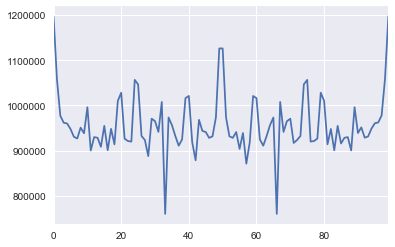

In [65]:
sns.tsplot(cell_type_counts['total'])

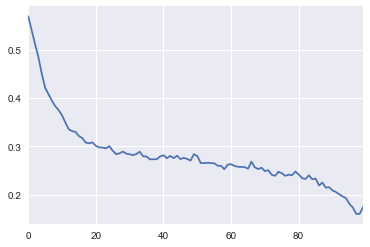

In [62]:
sns.tsplot(cell_type_counts['markdown_pct'])

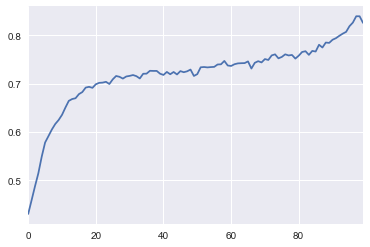

In [63]:
sns.tsplot(cell_type_counts['code_pct'])

In [14]:
# cell_type_dist = df_cell.iloc[0:100].groupby('cell_index')['cell_type'].value_counts()
# cell_type_dist = df_cell.groupby(['cell_index', 'cell_type']).size().unstack(fill_value=0)

# 3. Debug Code

There is an issues with the boundaries in my binning above. Let's fix that, and redo the analysis, also considering the amount of code or markdown in each cell.

In [14]:
def count_types(df):
    # create a master count array for code and for markdown
    markdown_counts = np.zeros(100)
    code_counts = np.zeros(100)
    other_counts = np.zeros(100)
    
    markdown_counts_prop = np.zeros(100)
    code_counts_prop = np.zeros(100)

    for i, row in df.iterrows():
        
        ci = row['cell_index']
        nc = float(row['num_cells'])
        
        start = int(math.ceil((ci) / nc * 100))
        end = int(math.ceil((ci + 1) / nc * 100))
        
        if row['cell_type'] in ['heading', 'markdown']:
            markdown_counts[start: end] += 1
            if row['num_words_x'] > 0 and row['num_words_y'] > 0:
                markdown_counts_prop[start: end] += (row['num_words_x'] / row['num_words_y'])

        elif row['cell_type'] == 'code':
            code_counts[start: end] += 1
            if row['lines_of_code_x'] > 0 and row['lines_of_code_y'] > 0:
                code_counts_prop[start: end] += (row['lines_of_code_x'] / row['lines_of_code_y'])
        
        else:
            other_counts[start:end] += 1
            
        # print("%s : %s" % (start, end))
        
    return markdown_counts, code_counts, other_counts, markdown_counts_prop, code_counts_prop

In [15]:
mc, cc, oc, mcp, ccp = count_types(df_cell_w_stats_100)

KeyboardInterrupt: 

In [ ]:
tt = mc + cc + oc

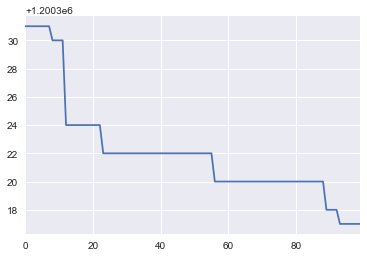

In [153]:
sns.tsplot(tt)

In [156]:
tt[0]

1200331.0

Okay, so it looks like we have fairly complete data, with only 14 notebooks not being accounted for across the whole range. This should not throw off our analysis much. Overall we have cell data for 1.2 million notebooks

## 4. Markdown vs. Code Distribution Code

We see dramatic dropoff in the proportion of the notebook devoted to code versus markdown.

In [ ]:
f, ax = plt.subplots(figsize=(16, 6))
sns.tsplot(cc / tt[0], ax = ax)
sns.tsplot(mc/ tt[0], ax = ax, color='green')

ax.set_title("Probability Cell will be Markdown (green) or Code (blue)")
ax.set_xlabel('% of nb length')
ax.set_ylabel('% of cells')
ax.set_ylim(0,1)

## Content

I had attempted to account for the amount of content in each cell (e.g. if a markdown cell at the beginning has most of the words in it, and the later cells have far fewer words. However, looking at these plots it seems I messed something up with my normalization of the data. I think I need to account for the size of the range. 

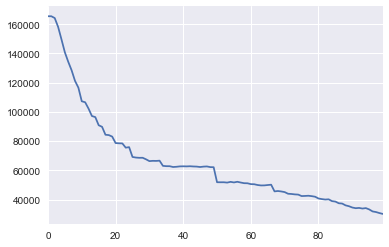

In [159]:
sns.tsplot(mcp)

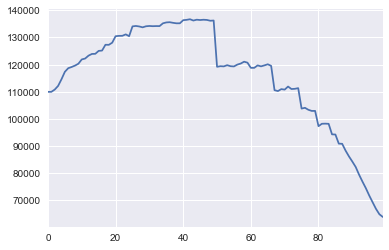

In [160]:
sns.tsplot(ccp)

## 5.0 Fix Content normalization

Let's see if I can fix that accounting now. The main change will be dividing the factor by the length of area being covered.

In [11]:
def count_types(df):
    # create a master count array for code and for markdown
    markdown_counts = np.zeros(100)
    code_counts = np.zeros(100)
    other_counts = np.zeros(100)
    
    markdown_counts_prop = np.zeros(100)
    code_counts_prop = np.zeros(100)

    for i, row in df.iterrows():
        
        ci = row['cell_index']
        nc = float(row['num_cells'])
        
        start = int(math.ceil((ci) / nc * 100))
        end = int(math.ceil((ci + 1) / nc * 100))
        
        if row['cell_type'] in ['heading', 'markdown']:
            markdown_counts[start: end] += 1
            if row['num_words_x'] > 0 and row['num_words_y'] > 0 and (end - start) > 0:
                markdown_counts_prop[start: end] += (row['num_words_x'] / row['num_words_y'] / (end-start))

        elif row['cell_type'] == 'code':
            code_counts[start: end] += 1
            if row['lines_of_code_x'] > 0 and row['lines_of_code_y'] > 0 and (end - start) > 0:
                code_counts_prop[start: end] += (row['lines_of_code_x'] / row['lines_of_code_y'] / (end-start))
        
        else:
            other_counts[start:end] += 1
            
        # print("%s : %s" % (start, end))
        
    return markdown_counts, code_counts, other_counts, markdown_counts_prop, code_counts_prop

In [32]:
mc2, cc2, oc2, mcp2, ccp2 = count_types(df_cell_w_stats_100)

In [33]:
tt = mc2 + cc2 + oc2

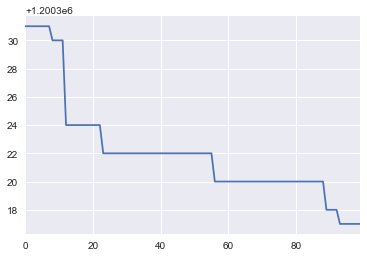

In [34]:
sns.tsplot(tt)

In [37]:
mc2

array([ 681656.,  681448.,  654927.,  617157.,  568850.,  527187.,
        505607.,  487427.,  473321.,  461993.,  443669.,  439591.,
        413673.,  408015.,  406886.,  397629.,  395129.,  384040.,
        383035.,  379163.,  376154.,  372965.,  374807.,  369496.,
        372040.,  365137.,  360575.,  357654.,  359874.,  362077.,
        357040.,  357851.,  356846.,  356890.,  354121.,  352277.,
        348171.,  345510.,  345743.,  350173.,  354475.,  352324.,
        352162.,  349882.,  349489.,  349945.,  348235.,  351741.,
        347730.,  347244.,  343713.,  342874.,  342404.,  338813.,
        341306.,  336659.,  337670.,  333627.,  327644.,  329946.,
        335442.,  335609.,  329883.,  329418.,  330650.,  327157.,
        328648.,  326520.,  329482.,  328495.,  327951.,  317874.,
        317334.,  310725.,  310494.,  311195.,  309976.,  312215.,
        313761.,  312618.,  313100.,  306846.,  304685.,  306701.,
        302247.,  300559.,  295462.,  291385.,  285329.,  2814

In [36]:
cc2

array([ 514994.,  515200.,  541735.,  579666.,  628083.,  669691.,
        691308.,  709530.,  723691.,  735056.,  753474.,  757596.,
        783589.,  789194.,  790477.,  799787.,  802285.,  813441.,
        814294.,  818300.,  821325.,  824478.,  822649.,  828030.,
        825632.,  832488.,  837053.,  839998.,  837752.,  835481.,
        840534.,  839665.,  840655.,  840677.,  843495.,  845396.,
        849503.,  852141.,  851914.,  847449.,  843182.,  845286.,
        845275.,  847589.,  848000.,  847586.,  849255.,  845752.,
        849898.,  850378.,  853871.,  854733.,  855173.,  858797.,
        856230.,  860940.,  859885.,  863936.,  869819.,  867485.,
        862096.,  861969.,  867676.,  868129.,  866899.,  870316.,
        868856.,  871076.,  868137.,  868989.,  869457.,  879736.,
        880315.,  886935.,  887236.,  886444.,  887696.,  885323.,
        883786.,  884833.,  884267.,  890520.,  892417.,  890549.,
        895038.,  896762.,  901804.,  905843.,  911923.,  9159

In [38]:
oc2

array([ 3681.,  3683.,  3669.,  3508.,  3398.,  3453.,  3416.,  3374.,
        3318.,  3281.,  3187.,  3143.,  3062.,  3115.,  2961.,  2908.,
        2910.,  2843.,  2995.,  2861.,  2845.,  2881.,  2868.,  2796.,
        2650.,  2697.,  2694.,  2670.,  2696.,  2764.,  2748.,  2806.,
        2821.,  2755.,  2706.,  2649.,  2648.,  2671.,  2665.,  2700.,
        2665.,  2712.,  2885.,  2851.,  2833.,  2791.,  2832.,  2829.,
        2694.,  2700.,  2738.,  2715.,  2745.,  2712.,  2786.,  2723.,
        2765.,  2757.,  2857.,  2889.,  2782.,  2742.,  2761.,  2773.,
        2771.,  2847.,  2816.,  2724.,  2701.,  2836.,  2912.,  2710.,
        2671.,  2660.,  2590.,  2681.,  2648.,  2782.,  2773.,  2869.,
        2953.,  2954.,  3218.,  3070.,  3035.,  2999.,  3054.,  3092.,
        3068.,  3005.,  2959.,  2691.,  2662.,  2673.,  2734.,  2774.,
        2756.,  2832.,  2795.,  2823.])

In [78]:
x = np.arange(100)
x.shape

y = cc2/tt[0]
y.shape

(100,)

In [1]:
f, ax = plt.subplots(figsize=(8, 6))


x = np.arange(100)
y1 = cc2 / tt[0]

ax.fill_between(x, 0, 1-y1, facecolor='steelblue')
ax.fill_between(x, 1, 1-y1, facecolor='lightsteelblue')

# sns.tsplot(cc2 / tt[0] * 100, ax = ax)
# sns.tsplot(mc2 /tt[0] * 100, ax = ax, color='green')

f.text(0.48, 0.2,'Text', fontsize=14, rotation=0, color = 'white')
f.text(0.48, 0.55,'Code', fontsize=14, rotation=0, color="white")

ax.set_title("Distribution of Notebook Content", fontsize = 16, color = 'grey', fontweight=600)
ax.set_xlabel('Section of Notebook', fontsize = 14, color = 'grey', fontweight=600)
ax.set_ylabel('Percent of Notebook Content', fontsize = 14, color = 'grey', fontweight=600)
ax.yaxis.tick_right()
ax.set_ylim(0,1)
ax.set_xlim(0,99)
plt.xticks([0,49,99], ['Start','Middle', 'End'], rotation=0, color='grey', fontsize = 14)
plt.yticks([0,0.2,0.4,0.6,0.8, 1], ['0%','20%','40%','60%','80%','100%'], rotation=0, color='grey', fontsize = 14)

NameError: name 'plt' is not defined

In [77]:
y1.shape

(200,)

In [53]:
np.arange(101)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

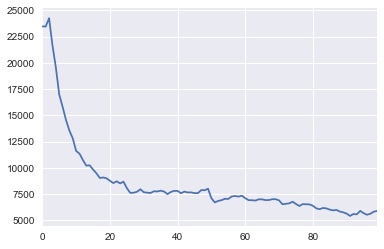

In [187]:
sns.tsplot(mcp2)

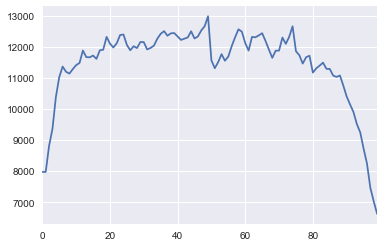

In [188]:
sns.tsplot(ccp2)

Hmm, these plots don't have the correct scale yet. I would have done well to count the number of notebooks that had markdown or code in them. I think I can calculate that now and redo the graphs.

In [190]:
nbs_w_markdown = df_cell_w_stats_100[df_cell_w_stats_100.num_words_y > 0]['nb_id'].unique().shape[0]
nbs_w_code = df_cell_w_stats_100[df_cell_w_stats_100.lines_of_code_y > 0]['nb_id'].unique().shape[0]

print('%s notebooks with markdown' % nbs_w_markdown)
print('%s notebooks with code' % nbs_w_code)

855559 notebooks with markdown
1144626 notebooks with code


(0, 0.03)

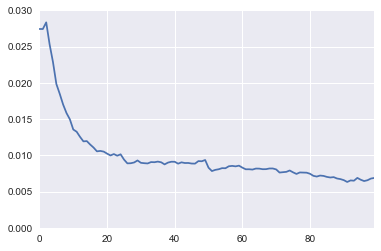

In [193]:
ax = sns.tsplot(mcp2 / nbs_w_markdown)
ax.set_ylim(0,0.03)

(0, 0.012)

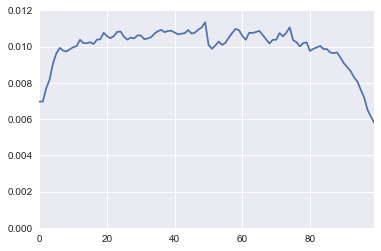

In [194]:
ax = sns.tsplot(ccp2 / nbs_w_code)
ax.set_ylim(0,0.012)

And to check that our normalization worked reasonably well, we can take the sum of the arrays.

In [195]:
mcp2.sum() / nbs_w_markdown

0.9889004254600533

In [196]:
ccp2.sum() / nbs_w_code

0.99995656616987849

The markdown is a little off, but still reasonably close. The code is really close. now let's put the two togeter

## Final Plots

(0, 100)

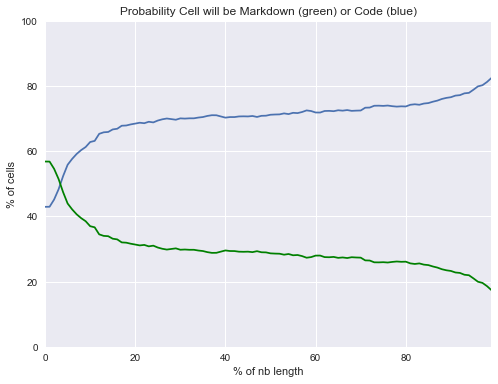

In [220]:
f, ax = plt.subplots(figsize=(8, 6))
sns.tsplot(cc / tt[0] * 100, ax = ax)
sns.tsplot(mc/ tt[0] * 100, ax = ax, color='green')

ax.set_title("Probability Cell will be Markdown (green) or Code (blue)")
ax.set_xlabel('% of nb length')
ax.set_ylabel('% of cells')
ax.set_ylim(0,100)

(0, 3)

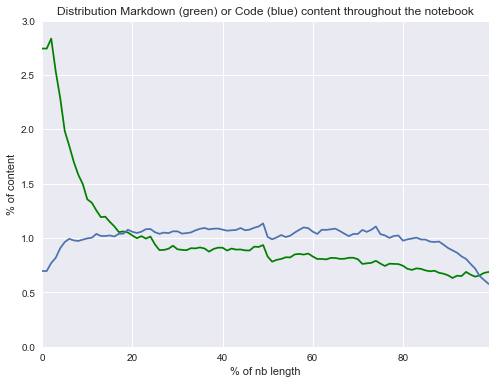

In [219]:
f, ax = plt.subplots(figsize=(8, 6))
sns.tsplot(mcp2 / nbs_w_markdown * 100, ax = ax, color='green')
sns.tsplot(ccp2 / nbs_w_code * 100, ax = ax)

ax.set_title("Distribution Markdown (green) or Code (blue) content throughout the notebook")
ax.set_xlabel('% of nb length')
ax.set_ylabel('% of content')
ax.set_ylim(0,3)

In [218]:
mcp2[91:100].sum() / nbs_w_markdown * 100

5.9560252922110095

These final plots ended up being reused.